# Densenet Architecture Implementation

### Data Prepare

Tham khảo :
1. https://amaarora.github.io/posts/2020-08-02-densenets.html#densenet-architecture-implementation
2. https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from imutils import paths
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
import os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/5_AIADVANCE')

In [4]:
root_dir = '/content/drive/MyDrive/5_AIADVANCE/GK_AI_Advance/'

# Đường dẫn tới thư mục con 'train', 'val' và 'test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

In [10]:
img_size = (224 , 224)
batch_size = 4
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'binary' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 3499 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Found 502 images belonging to 2 classes.


### DenseNet

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
import math
import sys

class BottleNeck(tf.keras.Model):
    def __init__(self, in_channels, growth_rate):
        super(BottleNeck, self).__init__()
        self.bn1 = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(4*growth_rate, kernel_size=1, use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(growth_rate, kernel_size=3, padding='same', use_bias=False)

    def call(self, x):
        out = self.conv1(tf.keras.activations.relu(self.bn1(x)))
        out = self.conv2(tf.keras.activations.relu(self.bn2(out)))
        out = layers.concatenate([out, x])
        return out

class Transition(tf.keras.Model):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = layers.BatchNormalization()
        self.conv = layers.Conv2D(out_channels, kernel_size=1, use_bias=False)
        self.avg_pool2d = layers.AveragePooling2D(pool_size=2)

    def call(self, x):
        out = self.conv(tf.keras.activations.relu(self.bn(x)))
        out = self.avg_pool2d(out)
        return out

class BuildDenseNet(tf.keras.Model):
    def __init__(self, block, num_blocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(BuildDenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_channels = 2*growth_rate
        self.conv1 = layers.Conv2D(num_channels, kernel_size=3, padding='same', use_bias=False)

        self.dense1 = self._make_layer(block, num_channels, num_blocks[0])
        num_channels += num_blocks[0] * growth_rate
        out_channels = int(math.floor(num_channels*reduction))
        self.trans1 = Transition(num_channels, out_channels)
        num_channels = out_channels

        self.dense2 = self._make_layer(block, num_channels, num_blocks[1])
        num_channels += num_blocks[1] * growth_rate
        out_channels = int(math.floor(num_channels*reduction))
        self.trans2 = Transition(num_channels, out_channels)
        num_channels = out_channels

        self.dense3 = self._make_layer(block, num_channels, num_blocks[2])
        num_channels += num_blocks[2] * growth_rate
        out_channels = int(math.floor(num_channels*reduction))
        self.trans3 = Transition(num_channels, out_channels)
        num_channels = out_channels

        self.dense4 = self._make_layer(block, num_channels, num_blocks[3])
        num_channels += num_blocks[3] * growth_rate

        self.bn = layers.BatchNormalization()
        self.avg_pool2d = layers.AveragePooling2D(pool_size=4)
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = tf.keras.activations.relu(self.bn(self.dense4(out)))
        out = self.avg_pool2d(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

    def _make_layer(self, block, in_channels, num_block):
        layer = []
        for i in range(num_block):
            layer += [block(in_channels, self.growth_rate)]
            in_channels += self.growth_rate
        return tf.keras.Sequential(layer)

def DenseNet(model_type, num_classes):
    if model_type == 'densenet121':
        return BuildDenseNet(BottleNeck, [6, 12, 24, 16], growth_rate=32, num_classes=num_classes)
    elif model_type == 'densenet161':
        return BuildDenseNet(BottleNeck, [6, 12, 36, 24], growth_rate=48, num_classes=num_classes)
    elif model_type == 'densenet169':
        return BuildDenseNet(BottleNeck, [6, 12, 32, 32], growth_rate=32, num_classes=num_classes)
    elif model_type == 'densenet201':
        return BuildDenseNet(BottleNeck, [6, 12, 48, 32], growth_rate=32, num_classes=num_classes)
    else:
        sys.exit(ValueError("{:s} is currently not supported.".format(model_type)))

### Tiền xử lí dữ liệu

### Xây dựng model

In [12]:
denseNet = DenseNet(model_type = 'densenet121', num_classes = 2)

In [13]:
denseNet.build((1, 224, 224, 3))
denseNet.summary()

Model: "build_dense_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         multiple                  1728      
                                                                 
 sequential_4 (Sequential)   (1, 224, 224, 256)        338304    
                                                                 
 transition_3 (Transition)   multiple                  33792     
                                                                 
 sequential_5 (Sequential)   (1, 112, 112, 512)        930048    
                                                                 
 transition_4 (Transition)   multiple                  133120    
                                                                 
 sequential_6 (Sequential)   (1, 56, 56, 1024)         2873856   
                                                                 
 transition_5 (Transition)   multiple            

In [14]:
# Tạo đối tượng optimizer  # SGD
optimizer = tf.keras.optimizers.Adam()

# Thiết lập ModelCheckpoint
save_best_only = True
checkpoint = ModelCheckpoint('models/model-DenseNet-{epoch:03d}.keras',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

# Xây dựng quy trình huấn luyện
denseNet.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
# H = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2, callbacks=[checkpoint])
H = denseNet.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // train_gen.batch_size,
    validation_data = valid_gen,
    validation_steps = valid_gen.samples // valid_gen.batch_size,
    epochs = 20,
    callbacks=[checkpoint]
)

Epoch 1/20
874/874 [==============================] - ETA: 0s - loss: 1.6618 - accuracy: 0.5505
Epoch 1: val_loss improved from inf to 5.89411, saving model to models/model-DenseNet-001.keras


874/874 [==============================] - 910s 945ms/step - loss: 1.6618 - accuracy: 0.5505 - val_loss: 5.8941 - val_accuracy: 0.6024
Epoch 2/20
874/874 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.5714
Epoch 2: val_loss improved from 5.89411 to 0.67131, saving model to models/model-DenseNet-002.keras


874/874 [==============================] - 574s 656ms/step - loss: 0.7636 - accuracy: 0.5714 - val_loss: 0.6713 - val_accuracy: 0.5894
Epoch 3/20
 27/874 [..............................] - ETA: 8:42 - loss: 0.7070 - accuracy: 0.6296

KeyboardInterrupt: 

### Evaluate

In [ ]:
# Vẽ đồ thị loss, accuracy của traning set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy') # sử dụng từ khóa accuracy thay vì acc
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy') # sử dụng từ khóa val_accuracy thay vì val_acc
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [16]:
# Đánh giá model với dữ liệu test set
score = denseNet.evaluate(test_gen, verbose=1)
print(score)

126/126 [==============================] - 134s 1s/step - loss: 0.6833 - accuracy: 0.6096
[0.6832879781723022, 0.6095617413520813]


In [ ]:
# model.summary()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán
preds = denseNet.predict(test_gen)
preds = np.argmax(preds, axis=1)

# Lấy nhãn thật
true_labels = test_gen.classes

# Tính các chỉ số
report = classification_report(true_labels, preds, output_dict=True)

# In chỉ số f1, precision, recall
print("F1:", report['weighted avg']['f1-score'])
print("Precision:", report['weighted avg']['precision'])
print("Recall:", report['weighted avg']['recall'])

126/126 [==============================] - 20s 147ms/step
F1: 0.6096361398891217
Precision: 0.6098846518687157
Recall: 0.6095617529880478


In [18]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62       258
           1       0.60      0.61      0.60       244

    accuracy                           0.61       502
   macro avg       0.61      0.61      0.61       502
weighted avg       0.61      0.61      0.61       502



In [29]:
len(test_gen[0][0][0])

224

In [41]:
print(img.dtype)

float32


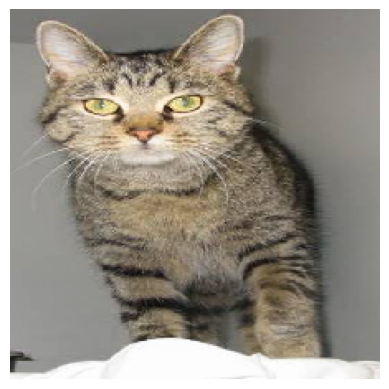

1/1 [==============================] - 0s 56ms/step
Dự đoán: 0


In [43]:
# Lấy 1 batch dữ liệu từ generator
batch = next(test_gen)
# In hình ảnh đầu tiên
img = batch[0][0]
img = img.astype(float)/255
plt.imshow(img)
plt.axis('off')
plt.show()

# Chuyển đổi thành 4D tensor
img = np.expand_dims(img, axis=0)

# Dự đoán
pred = denseNet.predict(img)
print('Dự đoán:', np.argmax(pred))

In [45]:
# Tính confusion matrix
conf_mat = confusion_matrix(true_labels, preds)

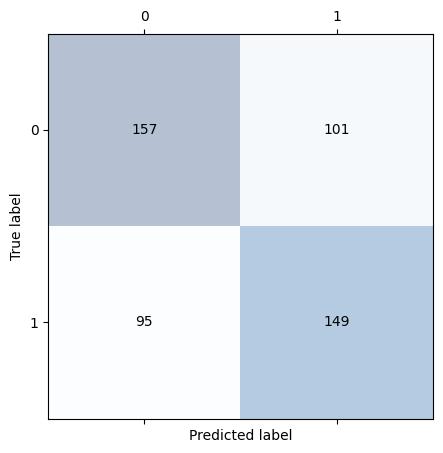

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i,j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()